# Speech Emotion Recognition

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os
import librosa
import random
from pydub import AudioSegment

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from transformers import AutoModel
from transformers import Wav2Vec2FeatureExtractor

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from imblearn.over_sampling import RandomOverSampler
from torchvision import transforms
from torch.utils.data import ConcatDataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Setting up the GPU

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [3]:
Wav2Vec2FeatureExtractor.model_input_names

['input_values', 'attention_mask']

In [4]:
# set random seed
random_seed = 5
torch.manual_seed(random_seed)
random.seed(random_seed)
np.random.seed(random_seed)

## Introdcution to Speech Dataset

### Data Processing

In [5]:
def load_data(root_dir):
    labels = []
    emotion = []
    speeches_path = []
    name_to_label = {'A':'anger' , 'H':'happiness' , 'N':'neutral' ,
                    'S':'sadness' , 'W':'surprise' , 'F':'fear' }
    for filename in os.listdir(root_dir):
            emotion_label = filename[3]
            for key in name_to_label:
                if key == emotion_label:
                    emotion_label = name_to_label[key]
            speeches_path.append(os.path.join(root_dir, filename))
            labels.append(emotion_label)
            emotion.append(emotion_label)
    label_encoder = preprocessing.LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    df = pd.DataFrame({"path": speeches_path, "label": labels, "emotion": emotion})
    return df, label_encoder

In [6]:
# modify the root path based on your environment
root_dir1 = '/kaggle/input/shemo-persian-speech-emotion-detection-database/female'
root_dir2 = '/kaggle/input/shemo-persian-speech-emotion-detection-database/male'
df1, label_encoder = load_data(root_dir1)
df2, _ = load_data(root_dir2)
df = pd.concat([df1, df2], ignore_index=True)
print(df)

                                                   path  label   emotion
0     /kaggle/input/shemo-persian-speech-emotion-det...      0     anger
1     /kaggle/input/shemo-persian-speech-emotion-det...      0     anger
2     /kaggle/input/shemo-persian-speech-emotion-det...      3   neutral
3     /kaggle/input/shemo-persian-speech-emotion-det...      4   sadness
4     /kaggle/input/shemo-persian-speech-emotion-det...      5  surprise
...                                                 ...    ...       ...
2995  /kaggle/input/shemo-persian-speech-emotion-det...      0     anger
2996  /kaggle/input/shemo-persian-speech-emotion-det...      5  surprise
2997  /kaggle/input/shemo-persian-speech-emotion-det...      3   neutral
2998  /kaggle/input/shemo-persian-speech-emotion-det...      4   sadness
2999  /kaggle/input/shemo-persian-speech-emotion-det...      0     anger

[3000 rows x 3 columns]


### Data Distribution

In [7]:
def data_distribution(df):
    classes_counts = df.groupby('emotion').size().reset_index(name='count')
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes_counts)))
    plt.bar(classes_counts['emotion'], classes_counts['count'], color=colors)
    for i, v in enumerate(classes_counts['count']):
        plt.text(i, v + 5, str(v), ha='center', va='bottom', fontsize=8)
    classes_names = df['emotion'].unique() 
    plt.xticks(classes_counts['emotion'], classes_names, size=10, rotation=45)
    plt.xlabel('Class', size=12)
    plt.ylabel('Frequency', size=12)
    plt.title('Class Distribution of Dataset', size=13)
    plt.show()

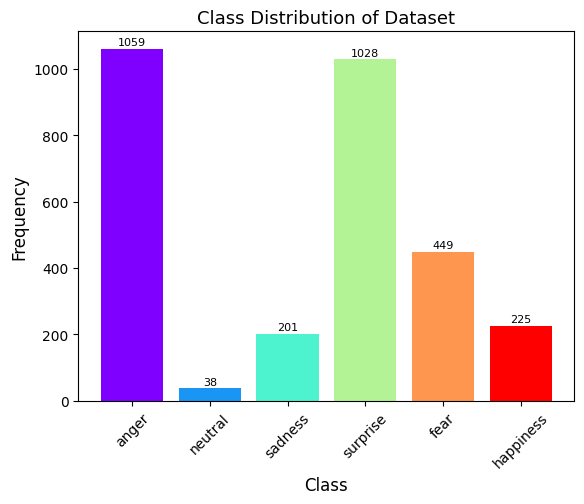

In [8]:
data_distribution(df)

### Audio Duration Distribution 

In [9]:
def audio_duration_distribution(df):
    durations = []
    all_sample_rates = set()
    for path in df['path']:
        audio, sr = librosa.load(path, sr=None)
        duration = librosa.get_duration(y=audio)
        durations.append(duration)
        all_sample_rates.add(sr)
        
    plt.hist(durations, bins=50, edgecolor='black')
    plt.title('Audio Duration Distribution', size=13)
    plt.xlabel('Duration (seconds)', size=12)
    plt.ylabel('Count', size=12)
    plt.show()
    
    mean_length = np.mean(durations)
    std_length = np.std(durations)

    print(f'Mean Length: {mean_length:.2f}')
    print(f'Standard Deviation of Length: {std_length:.2f}')


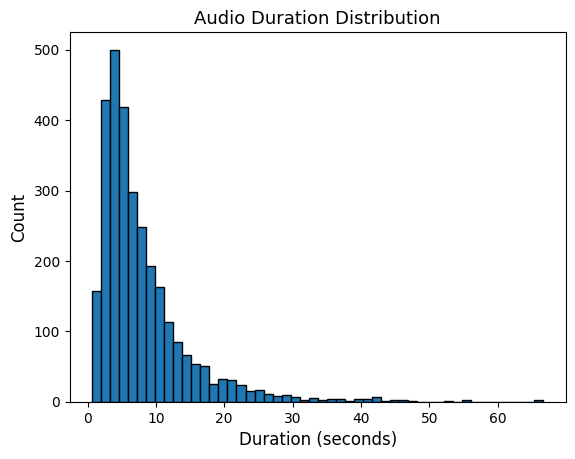

Mean Length: 8.03
Standard Deviation of Length: 6.82


In [10]:
audio_duration_distribution(df)

In [11]:
def audio_duration_distribution_by_class(df):
    class_durations = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []} 
    label_to_emotion = {0: [], 1: [], 2: [], 3: [], 4: [], 5: []} 

    for index, row in df.iterrows():
        path = row['path']
        label = row['label']
        emotion = row['emotion']
        
        audio, sr = librosa.load(path, sr=None)
        duration = librosa.get_duration(y=audio)
        class_durations[label].append(duration)
        label_to_emotion[label] = emotion

    for label, durations in class_durations.items():
        plt.hist(durations, bins=50, edgecolor='black')

        mean_length = np.mean(durations)
        std_length = np.std(durations)
        emotion = label_to_emotion.get(label)
        print(f'Class : {emotion}')
        title = 'Audio Duration Distribution by Class ' + emotion
        plt.title(title, size=13)
        plt.xlabel('Duration (seconds)', size=12)
        plt.ylabel('Count', size=12)
        plt.show()
        print(f'Mean Length: {mean_length:.2f}')
        print(f'Standard Deviation of Length: {std_length:.2f}')
        print()

Class : anger


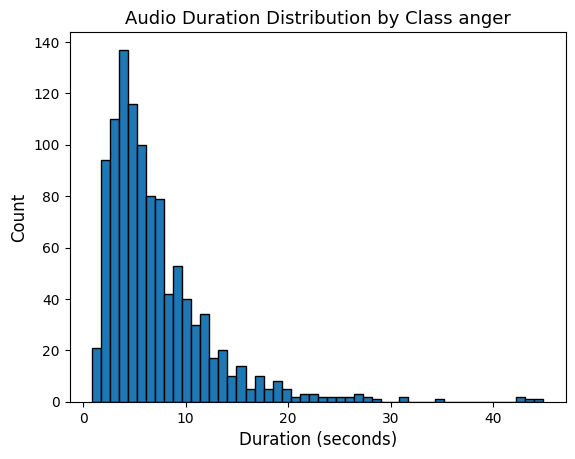

Mean Length: 7.19
Standard Deviation of Length: 5.27

Class : fear


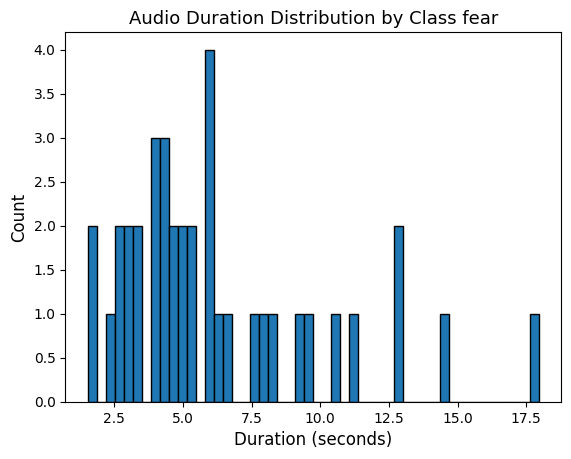

Mean Length: 6.28
Standard Deviation of Length: 3.68

Class : happiness


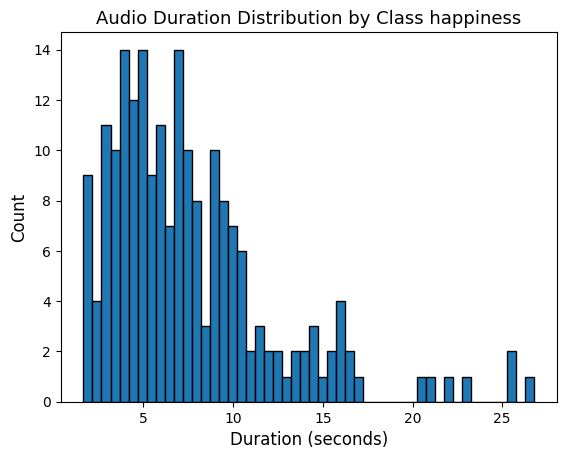

Mean Length: 7.59
Standard Deviation of Length: 4.72

Class : neutral


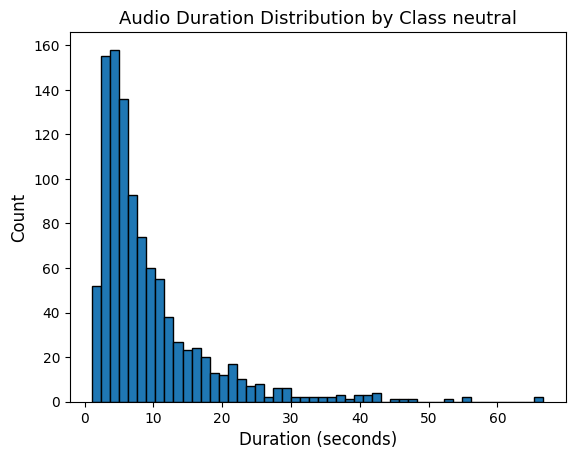

Mean Length: 9.34
Standard Deviation of Length: 8.28

Class : sadness


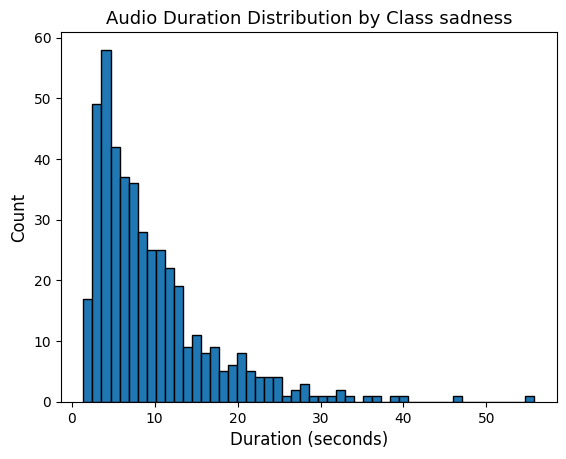

Mean Length: 9.63
Standard Deviation of Length: 7.39

Class : surprise


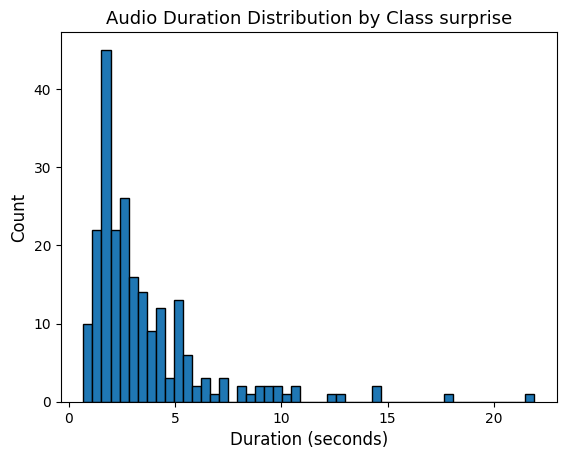

Mean Length: 3.54
Standard Deviation of Length: 2.92



In [12]:
audio_duration_distribution_by_class(df)

### Data Balancing

Function to apply time stretching, pitch shifting, and noise injection for data augementation and balancing

In [13]:
audio = AudioSegment.from_file('/kaggle/input/shemo-persian-speech-emotion-detection-database/female/F01A01.wav')
audio

In [14]:
def time_stretch(audio, factor):
    return audio.speedup(playback_speed=factor)

def pitch_shift(audio, semitones):
    return audio._spawn(audio.raw_data, overrides={
        "frame_rate": int(audio.frame_rate * (2 ** (semitones / 12.0)))
    })

def augment_audio(audio_path):
    audio = AudioSegment.from_file(audio_path)

    if random.choice([True, False]):
        audio = time_stretch(audio, random.uniform(0.8, 1.2))

    if random.choice([True, False]):
        audio = pitch_shift(audio, random.uniform(-2, 2))

    return audio

In [15]:
# Calculate the number of augmentations needed for each emotion
target_samples_per_emotion = 1059
emotion_counts = df['emotion'].value_counts()
augmentation_counts = {emotion: max(0, target_samples_per_emotion - count) for emotion, count in emotion_counts.items()}
print(augmentation_counts)

{'anger': 0, 'neutral': 31, 'sadness': 610, 'surprise': 834, 'happiness': 858, 'fear': 1021}


In [16]:
augmented_data = []
for emotion, count in augmentation_counts.items():
    samples_to_augment = df[df['emotion'] == emotion].sample(count, replace=True)
    for index, row in samples_to_augment.iterrows():
        augmented_audio = augment_audio(row['path'])
        name = row['path'].split('/')[-1]
        augmented_data.append({'path': f"augmented_{name}", 'label': row['label'], 'emotion': row['emotion']})
        augmented_audio.export(f"augmented_{name}", format="wav")

In [17]:
balanced_df = pd.DataFrame(augmented_data)
balanced_df = pd.concat([df, balanced_df], ignore_index=True)
print(balanced_df)

                                                   path  label   emotion
0     /kaggle/input/shemo-persian-speech-emotion-det...      0     anger
1     /kaggle/input/shemo-persian-speech-emotion-det...      0     anger
2     /kaggle/input/shemo-persian-speech-emotion-det...      3   neutral
3     /kaggle/input/shemo-persian-speech-emotion-det...      4   sadness
4     /kaggle/input/shemo-persian-speech-emotion-det...      5  surprise
...                                                 ...    ...       ...
6349                               augmented_M03F01.wav      1      fear
6350                               augmented_M44F01.wav      1      fear
6351                               augmented_F24F02.wav      1      fear
6352                               augmented_F16F01.wav      1      fear
6353                               augmented_M05F01.wav      1      fear

[6354 rows x 3 columns]


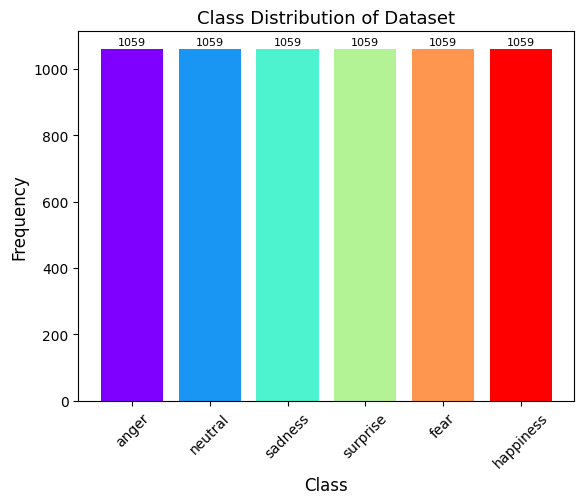

In [18]:
data_distribution(balanced_df)

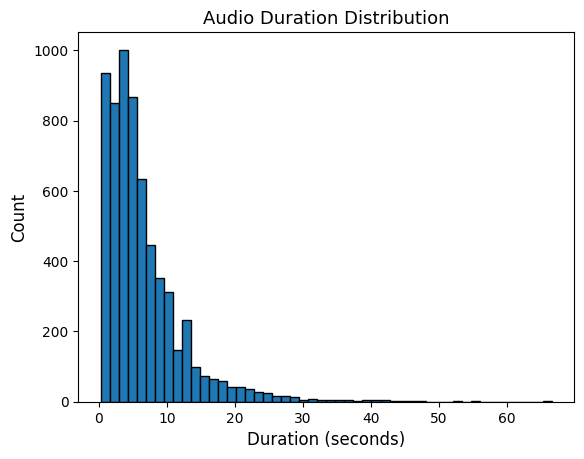

Mean Length: 6.48
Standard Deviation of Length: 6.05


In [19]:
audio_duration_distribution(balanced_df)

Class : anger


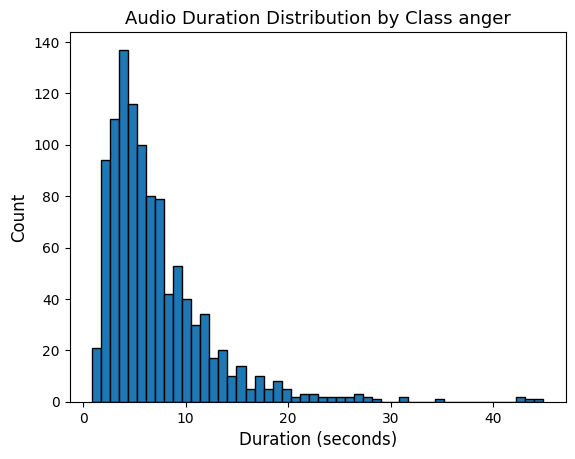

Mean Length: 7.19
Standard Deviation of Length: 5.27

Class : fear


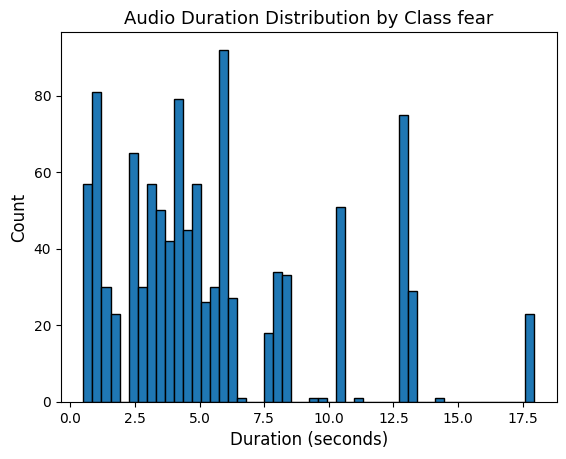

Mean Length: 5.51
Standard Deviation of Length: 3.98

Class : happiness


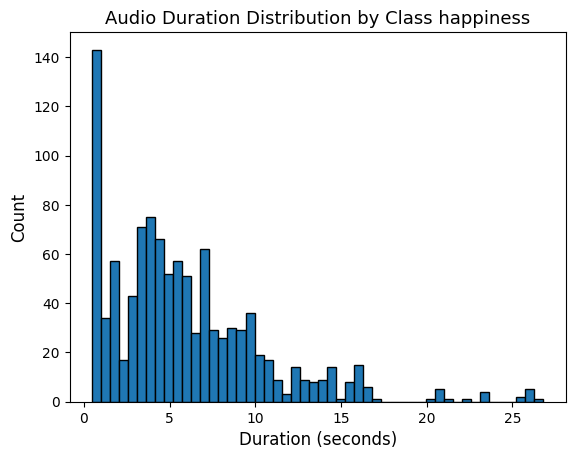

Mean Length: 5.88
Standard Deviation of Length: 4.57

Class : neutral


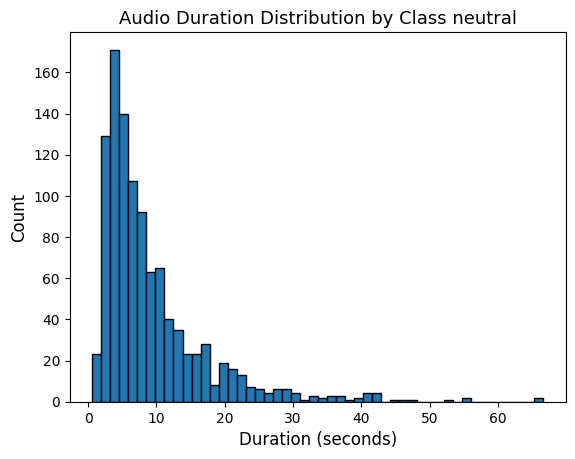

Mean Length: 9.33
Standard Deviation of Length: 8.29

Class : sadness


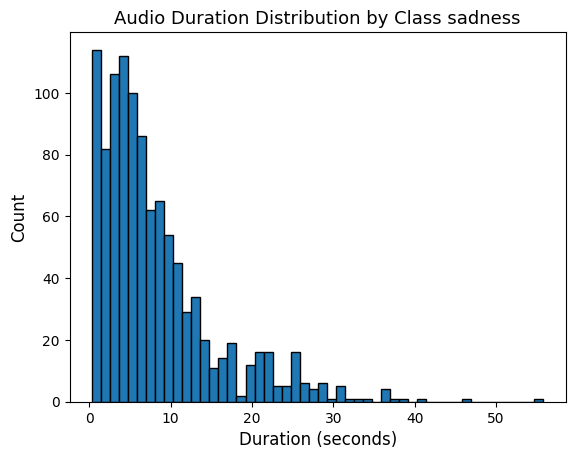

Mean Length: 8.20
Standard Deviation of Length: 7.26

Class : surprise


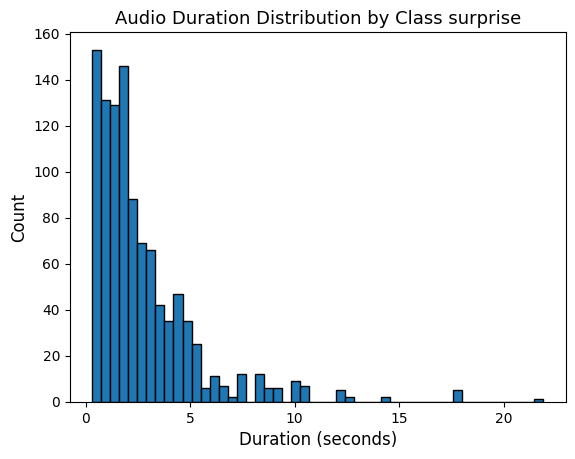

Mean Length: 2.74
Standard Deviation of Length: 2.54



In [20]:
audio_duration_distribution_by_class(balanced_df)

### Train, Test, Validation Split

In [21]:
train_df, temp_df = train_test_split(balanced_df, test_size=0.2, random_state=random_seed, stratify=balanced_df['label'], shuffle=True)
test_df, val_df = train_test_split(temp_df, test_size=0.5, random_state=random_seed, stratify=temp_df['label'], shuffle=True)

In [22]:
print('Number of train samples =', len(train_df))
print('Number of validation samples =', len(val_df))
print('Number of test samples =', len(test_df))    

Number of train samples = 5083
Number of validation samples = 636
Number of test samples = 635


### Building the Dataset and Dataloader

In [23]:
class SpeechDataset(Dataset):
    def __init__(self, data , feature_extractor):
        self.data = data
        self.feature_extractor = feature_extractor
        self.target_sr = 16e3 # target sampling rate
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        path = self.data.path.values[item]
        label = self.data.label.values[item]
        speech = self.file_to_array(path, self.target_sr)
        input_values = self.feature_extractor(speech , sampling_rate = self.target_sr).input_values[0]
        return input_values, label

    def file_to_array(self, path, sampling_rate):
        array, sr = librosa.load(path, sr= sampling_rate)
        return array

In [24]:
def collate_fn_padd(batch , feature_extractor):
    inputs, labels = zip(*batch)
    input_features = [{"input_values": feature} for feature in inputs]
    padded_inputs = feature_extractor.pad(input_features, padding=True, return_tensors="pt")
    labels = torch.tensor(labels, dtype=torch.long)
    return padded_inputs['input_values'], labels

def collate_fn(batch):
    return collate_fn_padd(batch, feature_extractor=tokenizer)

In [ ]:
tokenizer = Wav2Vec2FeatureExtractor.from_pretrained('facebook/hubert-base-ls960')
train_dataloader = DataLoader(SpeechDataset(train_df, tokenizer) , batch_size = 2, collate_fn = collate_fn, shuffle=True)
val_dataloader = DataLoader(SpeechDataset(val_df, tokenizer) , batch_size = 2, collate_fn = collate_fn, shuffle=True)
test_dataloader = DataLoader(SpeechDataset(test_df, tokenizer) , batch_size = 2, collate_fn = collate_fn, shuffle=True)

preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

In [26]:
print('Number of train batches =', len(train_dataloader))
print('Number of validaion batches =', len(val_dataloader))
print('Number of test batches =', len(test_dataloader))

Number of train batches = 2542
Number of validaion batches = 318
Number of test batches = 318


## Model 

In [ ]:
AutoModel.from_pretrained('facebook/hubert-base-ls960')

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

HubertModel(
  (feature_extractor): HubertFeatureEncoder(
    (conv_layers): ModuleList(
      (0): HubertGroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x HubertNoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): HubertFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): HubertEncoder(
    (pos_conv_embed): HubertPositionalConvEmbedding(
      (conv): Conv

In [28]:
class HuBERTClassificationModel(nn.Module):
    def __init__(self, num_classes):
        super(HuBERTClassificationModel, self).__init__()
        self.hubert = AutoModel.from_pretrained('facebook/hubert-base-ls960')
        self.fc1 = nn.Linear(self.hubert.config.hidden_size, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def freeze_feature_encoder(self):
        self.hubert.feature_extractor._freeze_parameters()

    def flattened_states(self, hidden_states):
        return torch.mean(hidden_states, dim=1)

    def forward(self, input_values, attention_mask=None):
        x = self.hubert(input_values, attention_mask=attention_mask).last_hidden_state
        x = self.flattened_states(x) 
        # Apply fully connected layers and activation for classification task
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x


### Loading the Model

In [29]:
num_classes = len(df.label.unique())
model = HuBERTClassificationModel(num_classes)
model.freeze_feature_encoder()
model = model.to(device)

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

### Loading the Optimizer and Loss Function

In [30]:
lr = 1e-5
weight_decay = 0.005
#optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.98))
criterion = nn.CrossEntropyLoss()

### Training

In [31]:
def train(model, dataloader, optimizer, criterion, epoch, device):
    model.train()
    losses, predictions, true_labels = [], [], []
    
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        if len(predictions) == 0:
            predictions = preds
            true_labels = labels
        else:
            predictions = np.concatenate((predictions, preds))
            true_labels = np.concatenate((true_labels, labels))

    print(f'Training Epoch = {epoch + 1} -> Loss = {np.mean(losses):.4f} , Accuracy = {accuracy_score(true_labels, predictions):.4f}')
    return np.mean(losses), accuracy_score(true_labels, predictions), predictions , true_labels

### Evaluatation

In [32]:
def evaluate(model, dataloader, criterion, device, epoch=0, test=False):
    model.eval()
    losses, predictions, true_labels = [], [], []

    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()

        if len(predictions) == 0:
            predictions = preds
            true_labels = labels
        else:
            predictions = np.concatenate((predictions, preds))
            true_labels = np.concatenate((true_labels, labels))
    if test:
        print(f'Test -> Loss = {np.mean(losses):.4f} , Accuracy = {accuracy_score(true_labels, predictions):.4f}')
    else:
        print(f'Validation Epoch = {epoch + 1} -> Loss = {np.mean(losses):.4f} , Accuracy = {accuracy_score(true_labels, predictions):.4f}')
    return np.mean(losses), accuracy_score(true_labels, predictions) , predictions , true_labels

### Plot accuracy and loss

In [33]:
def plot_loss_and_accuracy(loss, accuracy):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    axes[0].plot(loss[:, 0], label="Train loss")
    axes[0].plot(loss[:, 1], label="Validation loss")
    axes[0].set_ylabel("Loss", fontsize=12)
    axes[0].set_xlabel("Epoch", fontsize=12)
    axes[0].legend(prop={'size': 10})

    axes[1].plot(accuracy[:, 0], label="Train Accuracy")
    axes[1].plot(accuracy[:, 1], label="Validation Accuracy")
    axes[1].set_ylabel("Score", fontsize=12)
    axes[1].set_xlabel("Epoch", fontsize=12)
    axes[1].legend(prop={'size': 10})

    plt.tight_layout()
    plt.show()

Training Epoch = 1 -> Loss = 1.2472 , Accuracy = 0.5430
Validation Epoch = 1 -> Loss = 0.6885 , Accuracy = 0.7547
Training Epoch = 2 -> Loss = 0.7295 , Accuracy = 0.7574
Validation Epoch = 2 -> Loss = 0.4773 , Accuracy = 0.8302
Training Epoch = 3 -> Loss = 0.5190 , Accuracy = 0.8361
Validation Epoch = 3 -> Loss = 0.3773 , Accuracy = 0.8695
Training Epoch = 4 -> Loss = 0.4065 , Accuracy = 0.8682
Validation Epoch = 4 -> Loss = 0.3618 , Accuracy = 0.9009
Training Epoch = 5 -> Loss = 0.3325 , Accuracy = 0.8951
Validation Epoch = 5 -> Loss = 0.2697 , Accuracy = 0.9245
Training Epoch = 6 -> Loss = 0.2714 , Accuracy = 0.9127
Validation Epoch = 6 -> Loss = 0.3014 , Accuracy = 0.8994
Training Epoch = 7 -> Loss = 0.2349 , Accuracy = 0.9254
Validation Epoch = 7 -> Loss = 0.2491 , Accuracy = 0.9292
Training Epoch = 8 -> Loss = 0.2218 , Accuracy = 0.9333
Validation Epoch = 8 -> Loss = 0.2601 , Accuracy = 0.9167
Training Epoch = 9 -> Loss = 0.1923 , Accuracy = 0.9394
Validation Epoch = 9 -> Loss = 0

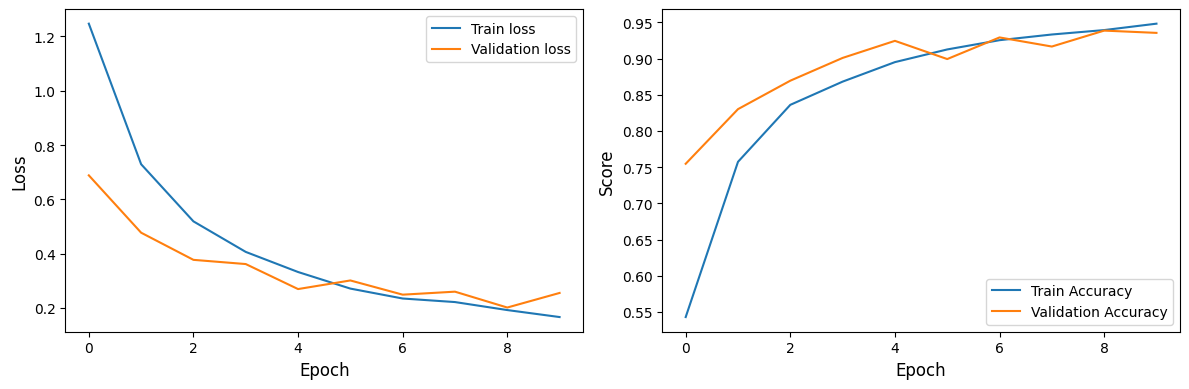

In [34]:
best_acc = 0
loss_list = []
acc_list = []
num_epochs = 10

for epoch in range(num_epochs):
    train_loss, train_acc , _ , _ = train(model, train_dataloader, optimizer, criterion, epoch, device)
    val_loss , val_acc , _ , _ = evaluate(model, val_dataloader, criterion, device, epoch)
    loss_list.append([train_loss, val_loss])
    acc_list.append([train_acc, val_acc])
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model, 'best-model.pt')
plot_loss_and_accuracy(np.array(loss_list), np.array(acc_list))

### Testing

In [35]:
def print_results_report(labels, preds, encoder):
    cm = confusion_matrix(labels, preds)
    preds = encoder.inverse_transform(preds)
    labels = encoder.inverse_transform(labels)
    classes_acc = []
    print("classes Accuracies")
    for class_ in encoder.classes_:
        acc = np.mean(preds[labels == class_] == class_)
        classes_acc.append(acc)
        print(class_ , ' Accuracy = ', acc)

    print(classification_report(labels, preds, labels = encoder.classes_))
    classes = encoder.classes_
    cm_df = pd.DataFrame(cm, index=classes, columns=classes)
    sns.heatmap(cm_df, annot=True, fmt='g')

Test -> Loss = 0.2212 , Accuracy = 0.9340
classes Accuracies
anger  Accuracy =  0.9056603773584906
fear  Accuracy =  1.0
happiness  Accuracy =  0.9811320754716981
neutral  Accuracy =  0.9245283018867925
sadness  Accuracy =  0.8867924528301887
surprise  Accuracy =  0.9056603773584906
              precision    recall  f1-score   support

       anger       0.96      0.91      0.93       106
        fear       1.00      1.00      1.00       106
   happiness       0.93      0.98      0.95       106
     neutral       0.80      0.92      0.86       106
     sadness       0.98      0.89      0.93       106
    surprise       0.96      0.91      0.93       106

    accuracy                           0.93       636
   macro avg       0.94      0.93      0.93       636
weighted avg       0.94      0.93      0.93       636



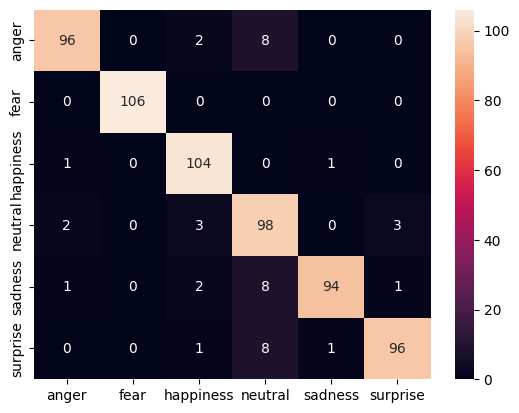

In [36]:
best_evaluated_model = torch.load('best-model.pt')
test_loss, test_acc, test_preds, test_labels = evaluate(best_evaluated_model, val_dataloader , criterion, device, test=True)
print_results_report(test_labels, test_preds, label_encoder)